# Finding Donors For A Charity

### by Yueh-Han Chen

### Project Overview
 In this project, I will employ several supervised algorithms of my choice to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than 50,000 dollars. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

### Dataset Overview
The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid". You can find the article by Ron Kohavi online. The data I investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

### Problem Statement
A charity wants to find out who is likely to donate. As a data scientist, I can utilize this dataset and supervised machine learning algorithms to predict potential donors for the charity to reach out.

# Process

> Step 1. Assessing

> Step 2. Preprocessing

> Step 3. Calculating the Performance of a Naive Predictor

> Step 4. Selecting 3 Appropriate Model Candidates 

> Step 5. Creating a Training and Predicting Pipeline

> Step 6. Initial Model Evaluation and Picking the Best Model

> Step 7. Model Tuning

> Step 8. Put testing set from Kaggle competition into the tuned model


### Gather

In [46]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [54]:
#load data
df = pd.read_csv('census.csv')

# Step 1: Assessing

In [55]:
# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [49]:
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [50]:
df.shape

(45222, 14)

In [51]:
df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


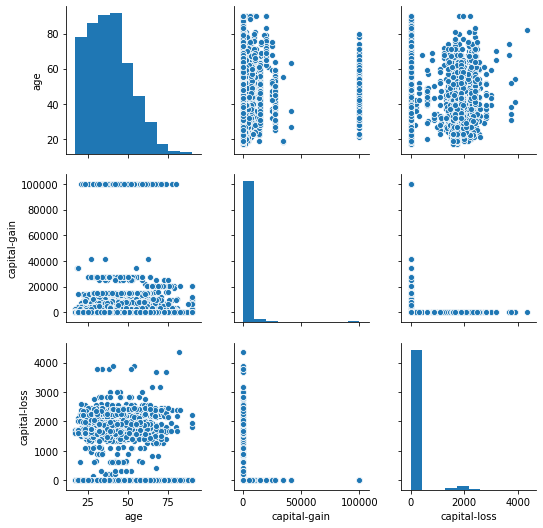

In [115]:
figure = sb.pairplot(df[['age','capital-gain','capital-loss']])
figure.savefig('distribution.png', dpi=400)

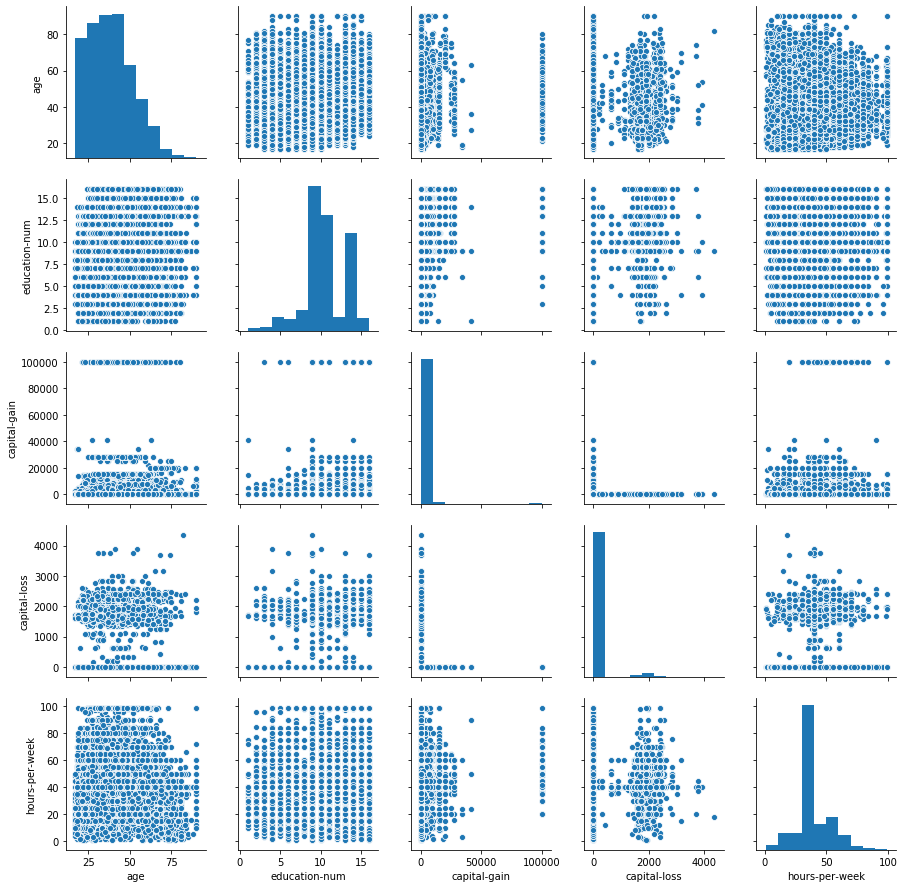

In [116]:
sb.pairplot(df)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [121]:
df[df.duplicated()].shape[0]

5982

In [142]:
df.drop_duplicates(inplace=True)
df[df.duplicated()].shape[0]

0

## Preprocessing Assessment Results:

1. Age, Capital-loss,Capital-gain are skewed to the right.
2. hours-per-week has outliers.
3. All numeric features shoulde be normalized.
4. The target varaible should be mapped into 1 and 0.
5. All categorical features should be one-hot encoded.

# Step 2: Preprocessing

#### Preprocessing 1: Age, Capital-loss,Capital-gain are skewed to the right.

In [56]:
# Log-transform the skewed features
skewed = ['age',
          'capital-gain', 'capital-loss']

df_log = df[skewed].apply(lambda x: np.log(x + 1))

df.drop(skewed , axis=1, inplace=True)
df = pd.concat([df, df_log], axis=1)

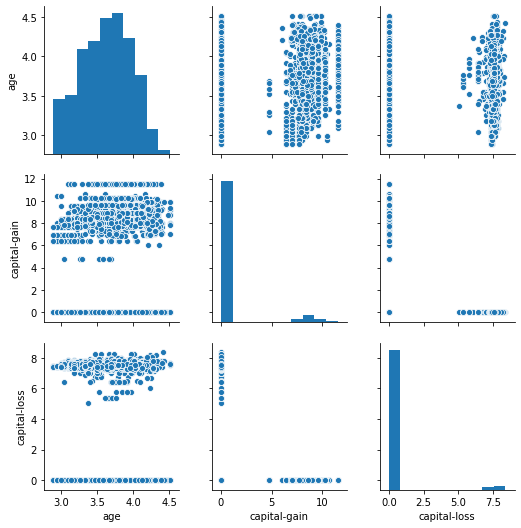

In [57]:
sb.pairplot(df_log)

#### Preprocessing 2: remove hours-per-week's outliers.

In [145]:
df['hours-per-week'].std()

12.45802079077719

In [146]:
df['hours-per-week'].describe()

count    39240.000000
mean        41.206091
std         12.458021
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

In [21]:
df = df[df['hours-per-week'] <= df['hours-per-week'].mean() + 3*df['hours-per-week'].std() ]
df = df[df['hours-per-week'] >= df['hours-per-week'].mean() - 3*df['hours-per-week'].std() ]

In [22]:
df.shape[0]

39506

#### Preprocessing 3: All numeric features shoulde be normalized.

In [58]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

df[numerical] = scaler.fit_transform(df[numerical])

In [59]:
df[numerical].describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.450785,0.607897,0.064342,0.042423,0.407531
std,0.210055,0.170192,0.214240,0.190454,0.122526
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.294309,0.533333,0.000000,0.000000,0.397959
50%,0.461105,0.600000,0.000000,0.000000,0.397959
75%,0.605268,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000,1.000000


#### Preprocessing 4: The target varaible should be mapped into 1 and 0.

In [60]:
df['income'] = df['income'].map({'>50K': 1, '<=50K': 0})

In [61]:
df.income.sample(10)

41021    0
11424    1
16351    1
453      0
32534    0
4186     0
25258    0
413      0
22692    0
10326    1
Name: income, dtype: int64

#### Preprocessing 5: All categorical features should be one-hot encoded.

In [62]:
df = pd.get_dummies(df)

In [63]:
df.head()

,education-num,hours-per-week,income,age,capital-gain,capital-loss,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_level_ 10th,education_level_ 11th,education_level_ 12th,education_level_ 1st-4th,education_level_ 5th-6th,education_level_ 7th-8th,education_level_ 9th,education_level_ Assoc-acdm,education_level_ Assoc-voc,education_level_ Bachelors,education_level_ Doctorate,education_level_ HS-grad,education_level_ Masters,education_level_ Preschool,education_level_ Prof-school,education_level_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.800000,0.397959,0,0.492758,0.667492,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.800000,0.122449,0,0.642679,0.000000,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.533333,0.397959,0,0.477134,0.000000,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.400000,0.397959,0,0.677952,0.000000,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.800000,0.397959,0,0.294309,0.000000,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Split the data into training set and testing set.

In [64]:
target = df.income
df.drop(['income'] , axis=1, inplace=True)

In [65]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


# Step 3: Calculating the Performance of a Naive Predictor

**The the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.**


* If we chose a model that always predicted an individual made more than 50,000 USD, what would  that model's accuracy and F-score be on this dataset?

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [46]:
target.sum(), target.shape[0]

(11001, 44445)

In [45]:
# Calculate accuracy, precision and recall
accuracy =  target.sum()/target.shape[0]
recall = target.sum()/target.sum()
precision = target.sum()/target.shape[0]

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2)*(precision*recall)/(0.5**2*precision + recall)
AUC = 0.5

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, AUC: {:.4f}, F-score: {:.4f}]".format(accuracy, AUC, fscore))

Naive Predictor: [Accuracy score: 0.2475, AUC: 0.5000, F-score: 0.2914]


# Step 4: Selecting 3 Appropriate Model Candidates

I will list three of the supervised learning models above that are appropriate for this problem that I will test on the census data. For each model chosen, I will answer the following questions:

1. What are the strengths of the model?
2. What are the weaknesses of the model?
3. What makes this model a good candidate for the problem, given what you know about the data?

### 3 Appropriate Model Candidates

1. Random Forest

    - What are the strengths of the model; when does it perform well?
    
        - Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process.
        - It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.
        - The algorithm can be used in both classification and regression problems.
        - Resource: (https://www.datacamp.com/community/tutorials/random-forests-classifier-python)
    
    - What are the weaknesses of the model; when does it perform poorly?
        - Random forests is slow in generating predictions because it has multiple decision trees. Whenever it makes a prediction, all the trees in the forest have to make a prediction for the same given input and then perform voting on it. This whole process 
        is time-consuming.
        - The model is difficult to interpret compared to a decision tree, where you can easily make a decision by following the path in the tree.
        - Resource: (https://www.datacamp.com/community/tutorials/random-forests-classifier-python)
    
    - What makes this model a good candidate for the problem, given what you know about the data?
        - Decision trees can handle many feaures, and this data has many features, 103 total, so it would be a good candidate.  
        - Random forest doesn't suffer from overfitting problem

2. Gradient Boosting Trees

    - What are the strengths of the model; when does it perform well?
        - Highly efficient on both classification and regression tasks
        - Can handle mixed type of features and no pre-processing is needed(https://towardsdatascience.com/gradient-boosted-decision-trees-explained-9259bd8205af)
    - What are the weaknesses of the model; when does it perform poorly?
        - GBDT training generally takes longer because of the fact that trees are built sequentially. (https://corporatefinanceinstitute.com/resources/knowledge/other/boosting/)
        - Requires careful tuning of hyperparameters
        - May overfit if too many trees are used (n_estimators)
        - Sensitive to outliers (https://towardsdatascience.com/gradient-boosted-decision-trees-explained-9259bd8205af)
    - What makes this model a good candidate for the problem, given what you know about the data?
        - Decision trees can handle many feaures, and this data has many features, 103 total, so it would be a good candidate.  
        - Many articles suggest it performs better than random forest, so I think it will be worth giving it a try.
        
3. XGBoost
 
    - What are the strengths of the model; when does it perform well?
        - Speed and performance : Originally written in C++, it is comparatively faster than other ensemble classifiers.
        - Works well on large dataset : Because the core XGBoost algorithm is parallelizable it can harness the power of multi-core computers. It is also parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as well.
        - Can be used in selecting important features.
        - Less feature engineering required (No need for normalizing data, can also handle missing values well)
        - Consistently outperforms other algorithm methods : It has shown better performance on a variety of machine learning benchmark datasets.
        - Wide variety of tuning parameters : XGBoost internally has parameters for cross-validation, regularization, user-defined objective functions, missing values, tree parameters, scikit-learn compatible API etc.
        - Outliers have minimal impact.
        - It performs well when data has mixture numerical and categorical features or just numeric features.
    - What are the weaknesses of the model; when does it perform poorly?
        - Overfitting possible if parameters not tuned properly.
        - Harder to tune as there are too many hyperparameters.
        - When It's not suitable to use XGBoost: Image recognition, Computer vision, Natural language processing and understanding problems.
    - What makes this model a good candidate for the problem, given what you know about the data?
        - XGBoost is a frequent winners among Kaggle competitions. 
        - It supports both classification and regression problems.

# Step 5: Creating a Training and Predicting Pipeline

It's important to create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In here, I will use accuracy and area under curve to measure the models.

In [137]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    from time import time
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:int(X_train.shape[0]*sample_size)], y_train[:int(X_train.shape[0]*sample_size)])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute AUC on the the first 300 training samples using roc_auc_score()
    results['auc_train'] = roc_auc_score(y_train[:300], predictions_train)
        
    # Compute AUC on the test set which is y_test
    results['auc_test'] = roc_auc_score(y_test, predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

# Step 6: Initial Model Evaluation and Picking the Best Model

- Import the three supervised learning models I've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — I will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

In [27]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=42)
clf_B = GradientBoostingClassifier(random_state=42)
clf_C = xgb.XGBClassifier(random_state=42)

In [28]:
# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = 0.1*len(y_train)
samples_1 = 0.01*len(y_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

RandomForestClassifier trained on 355.56 samples.
RandomForestClassifier trained on 3555.6000000000004 samples.
RandomForestClassifier trained on 35556 samples.
GradientBoostingClassifier trained on 355.56 samples.
GradientBoostingClassifier trained on 3555.6000000000004 samples.
GradientBoostingClassifier trained on 35556 samples.
[14:10:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier trained on 355.56 samples.
[14:11:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier trained on 3555.6000000000004 samples.
[14:11:1

In [29]:
def evaluate(results):
    import matplotlib.patches as mpatches
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))
    # Constants
    bar_width = 0.3
    colors = ['navy','yellow','green']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'auc_train', 'pred_time', 'acc_test', 'auc_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("AUC")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("AUC")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("AUC on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("AUC on Testing Set")

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    plt.tight_layout()
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.show()

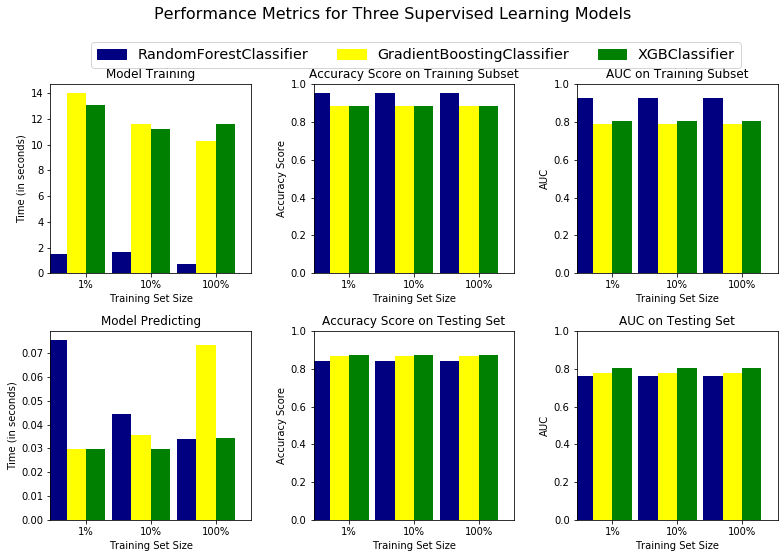

In [30]:
evaluate(results)

### Choosing the Best Model: XGBoost

1. We can see that Random Forest overfitted a bit as it has a high training score but a relatively low testing score. In contrast, XGBoost performs the best as it gets the highest testing score, and also, the training score and testing score are nearly the same, which means it's neither underfitting nor overfitting.
2. For the training time, although XGBoost spent the highest amount of time, but it only takes it 12 seconds, so it's acceptable in this dataset.
3. XGBoost performs way better than a naive predictor, which has only an accuracy of 0.2475 and an AUC of 0.5. And a unoptimized XGBoost has an accuracy of 0.85 and an AUC of 0.8

# Step 7: Model Tuning

## Model Tuning

In [31]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Initialize the classifier
clf =  xgb.XGBClassifier(random_state=42)

# Create the parameters list
parameters = {
    "learning_rate" : [0.1, 1],
    "n_estimators": [300, 400],
    'max_depth': [3, 5],
    'gamma' : [0.1, 0.3],
    'max_delta_step' : [1,3]
}

# Make an roc_auc_score scoring object using make_scorer()
#scorer = make_scorer(roc_auc_score)

# Perform random search on the classifier using 'scorer' as the scoring method using GridSearchCV()
random_obj = RandomizedSearchCV(clf, parameters)

# Fit the random search object to the training data and find the optimal parameters using fit()
random_fit = random_obj.fit(X_train, y_train)

# Get the estimator
best_clf = random_fit.best_estimator_

[14:11:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[14:21:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
# Make predictions using the unoptimized and model
acc_predictions = (clf.fit(X_train, y_train)).predict(X_test)
auc_predictions = (clf.fit(X_train, y_train)).predict_proba(X_test)[:,1]
acc_best_predictions = best_clf.predict(X_test)
auc_best_predictions = best_clf.predict_proba(X_test)[:,1]

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, acc_predictions)))
print("AUC on testing data: {:.4f}".format(roc_auc_score(y_test, auc_predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, acc_best_predictions)))
print("Final AUC on the testing data: {:.4f}".format(roc_auc_score(y_test, auc_best_predictions)))

[14:21:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Unoptimized model
------
Accuracy score on testing data: 0.8729
AUC on testing data: 0.9283

Optimized Model
------
Final accuracy score on the testing data: 0.8746
Final AUC on the testing data: 0.9292


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8729          |   0.8746        |
| AUC        |   0.9283          |   0.9292        |

In [45]:
random_fit.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [67]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score


xg_clf = xgb.XGBClassifier(learning_rate = 0.1, 
                            n_estimators = 400, 
                           max_depth = 5,
                           gamma = 0.1,
                           max_delta_step = 1,
                            seed=42)

xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, preds))
print("AUC: ", roc_auc_score(y_test, xg_clf.predict_proba(X_test)[:,1]))

[17:01:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8729684908789387
AUC:  0.9297024638315365


# Preprocessing the testing data from Kaggle Competition

In [68]:
df_test = pd.read_csv('test_census.csv')
df_test.drop(['Unnamed: 0'] , axis=1, inplace=True)

In [69]:
categorical_var = []
for i in list(df.columns):
    if i not in ['education-num', 'hours-per-week','age','capital-gain','capital-loss']:
        categorical_var.append(i)

In [70]:
# Log-transform the skewed features
skewed = ['age','capital-gain', 'capital-loss']

df_log = df_test[skewed].apply(lambda x: np.log(x + 1))

df_test.drop(skewed , axis=1, inplace=True)

df_test = pd.concat([df_test, df_log], axis=1)

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

df_test[numerical] = scaler.fit_transform(df_test[numerical])

# fill missing values for numeric variables with approximatelly gaussian dictribution:
for col in ['age', 'education-num', 'hours-per-week']:
    df_test[col]= df_test[col].fillna(df[col].mean())

# fill missing values for numeric variables with skewed dictribution:
for col in ['capital-gain', 'capital-loss']:
    df_test[col]= df_test[col].fillna(df[col].median())

#fill missing categorical values with most freaquent category in training data:
#load data
og_df = pd.read_csv('census.csv')

for col in categorical_var:
    if col in list(df_test.columns):
        df_test[col]= df_test[col].fillna(og_df.groupby([col])[col].count().sort_values(ascending=False).index[0])
        
df_test = pd.get_dummies(df_test)

In [71]:
xg_preds = xg_clf.predict_proba(df_test)[:, 1]

In [72]:
final = pd.DataFrame(list(xg_preds), columns = ['income'])
final = final.reset_index()
final.rename(columns={"index":"id"}, inplace = True)
final.head()

,id,income
0,0,0.015121
1,1,0.700765
2,2,0.253342
3,3,0.997523
4,4,0.043270


In [73]:
final.to_csv('final.csv', index=False)